In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2


# torch
import torch

# key_dynam
from key_dynam.utils.utils import get_project_root, get_data_root


# pdc
from dense_correspondence.dataset.dynamic_drake_sim_dataset import DynamicDrakeSimDataset
from dense_correspondence.correspondence_tools.correspondence_finder import reproject_pixels
from dense_correspondence.correspondence_tools import correspondence_plotter
from dense_correspondence.correspondence_tools.correspondence_finder import compute_correspondence_data, pad_correspondence_data
from dense_correspondence_manipulation.utils.utils import getDenseCorrespondenceSourceDir, getDictFromYamlFilename, get_data_dir
import dense_correspondence.loss_functions.utils as loss_utils
from dense_correspondence.dataset.spartan_episode_reader import SpartanEpisodeReader
from dense_correspondence_manipulation.utils.constants import DEPTH_IM_SCALE
import dense_correspondence_manipulation.utils.utils as pdc_utils

In [3]:
## Note that this only works for static scenes/episodes, not dynamic ones

In [4]:
def load_data():
    
    return load_spartan_data()


def load_spartan_data():
    #### SPARTAN ########
    
    # caterpillar
    dataset_processed_dir = os.path.join(get_data_root(), 'dev/pdc/2018-04-16-14-25-19/processed')
    
    # caterpillar
    episode_name = "2018-04-16-14-25-19"
    
    # shoe
    episode_name = "2018-05-14-22-57-40"
    dataset_processed_dir = os.path.join(get_data_dir(), "logs_proto", episode_name, 'processed')

    config_file = os.path.join(getDenseCorrespondenceSourceDir(), 'config/dense_correspondence/global/integral_heatmap_3d.yaml')
    config = getDictFromYamlFilename(config_file)
    
    episode = SpartanEpisodeReader(config, dataset_processed_dir)
    episode_name = "episode_0"
    multi_episode_dict = {episode_name: episode}
    return multi_episode_dict, config



setting fixed epoch size
data_a.keys() dict_keys(['rgb', 'depth_int16', 'mask', 'T_world_camera', 'K', 'camera_name', 'idx', 'episode_name'])
int32
max(depth) 1076


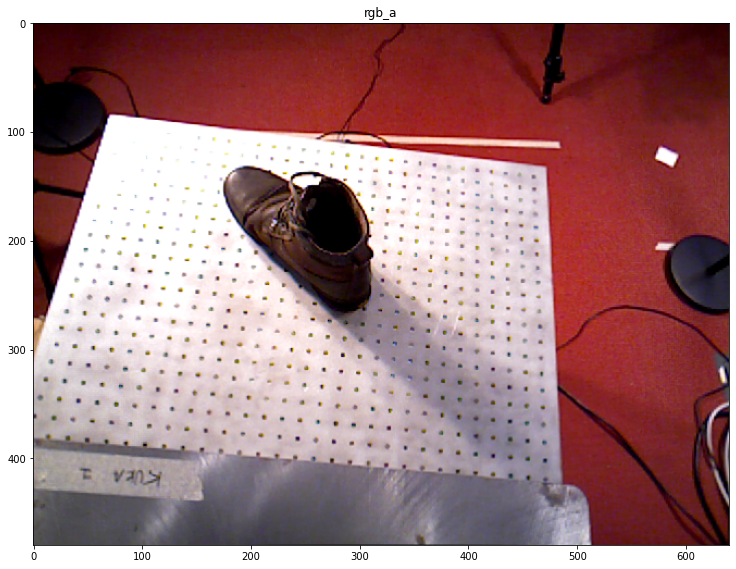

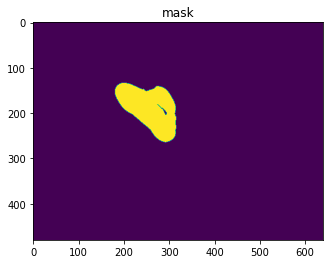

In [5]:

# episode, config = load_data()
multi_episode_dict, config = load_data()
episode_name = list(multi_episode_dict.keys())[0]
episode = multi_episode_dict[episode_name]
indices = episode.indices


sz = 2
figsize = (6.4*sz, 4.8*sz)


# episode_name = "episode_0"
# multi_episode_dict = {episode_name: episode}
# print("multi_episode_dict.keys()", multi_episode_dict.keys())


dataset = DynamicDrakeSimDataset(config, multi_episode_dict)


idx_a = indices[0]
idx_b = indices[20]
# idx_a = 0
# idx_b = 20
episode = multi_episode_dict[episode_name]

camera_names = list(episode.camera_names)
camera_name_a = camera_names[0]
camera_name_b = camera_names[0]

data_a = episode.get_image_data(camera_name_a, idx_a)
data_b = episode.get_image_data(camera_name_b, idx_b)

print("data_a.keys()", data_a.keys())

# plot RGB
plt.figure(figsize=figsize)
plt.imshow(data_a['rgb'])
plt.title('rgb_a')


# mask
mask = data_a['mask']
plt.figure()
plt.imshow(mask)
plt.title('mask')

depth = data_a['depth_int16']
print(depth.dtype)
print("max(depth)", np.max(depth))

## Visualize pointcloud with meshcat
Disable if you don't want to test this feature

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


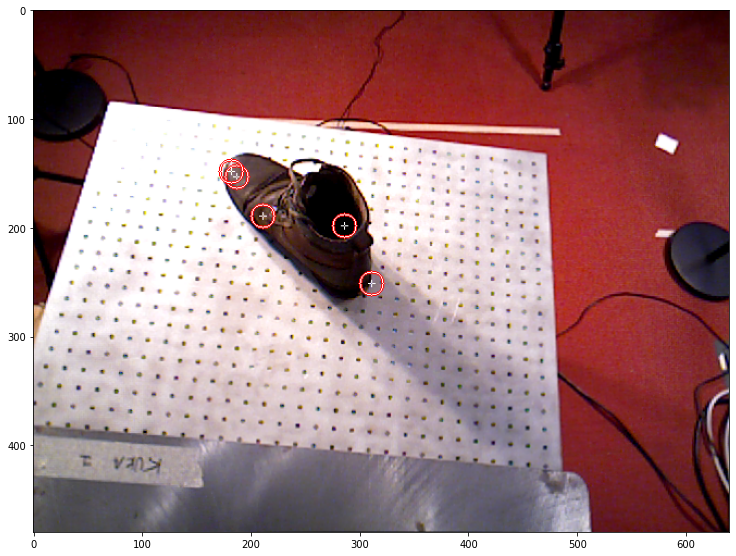

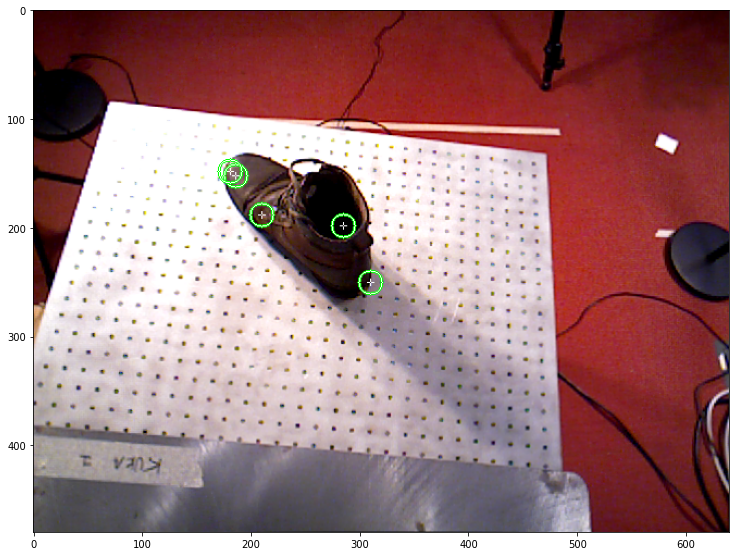

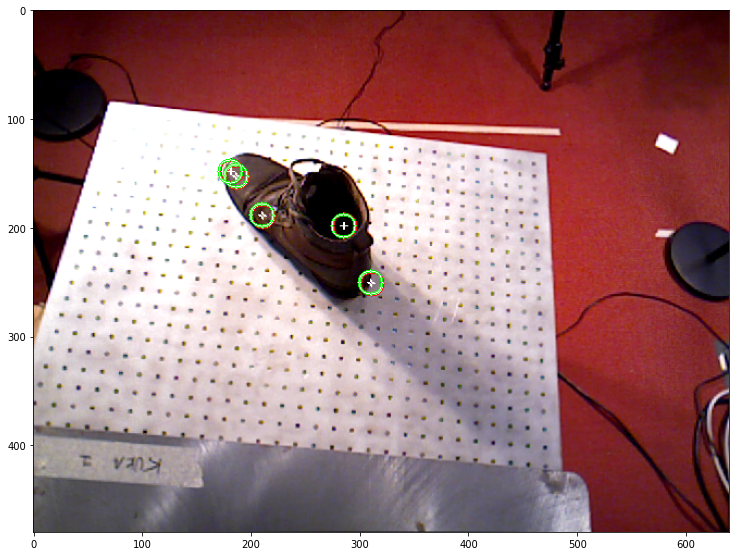

In [6]:
#%%

if True:
    
    # meshcat
    import meshcat
    import meshcat.geometry as g
    import meshcat.transformations as tf
    
    from dense_correspondence_manipulation.utils import meshcat_utils
    from dense_correspondence_manipulation.utils import utils as pdc_utils
    from dense_correspondence_manipulation.utils import torch_utils
    from dense_correspondence_manipulation.utils.constants import DEPTH_IM_SCALE
    from dense_correspondence_manipulation.utils.visualization import draw_reticles

    K = data_a['K']
    depth = data_a['depth_int16'] / DEPTH_IM_SCALE
    rgb = data_a['rgb']
    out = pdc_utils.project_image_to_pointcloud(depth, K, rgb)

    vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
    vis.delete()
    geom = g.Points(
        g.PointsGeometry(out['pts'].transpose(), color=out['color'].transpose()/255.0),
        g.PointsMaterial(size=0.001)
    )
    vis['pointcloud'].set_object(geom)

    # set the transform
    T_W_C = data_a['T_world_camera']
    # T_inv = np.linalg.inv(T_W_C)
    vis['pointcloud'].set_transform(T_W_C)


    
    ###### TEST pytorch unprojection method #############
    
    # test the pytorch unprojection method
    K_inv_np = np.linalg.inv(K)
    
    # [B, 3, 3]
    K_inv = torch.from_numpy(K_inv_np).unsqueeze(0)
    
    # [B, N, 2]
    mask = torch.Tensor(data_a['mask'])
    uv = torch_utils.random_sample_from_masked_image_torch(mask, 5)
    uv = uv.unsqueeze(0)
    
    # [B, 1, H, W]
    depth_tensor = torch.Tensor(depth).unsqueeze(0).unsqueeze(0)

    z = pdc_utils.index_into_batch_image_tensor(depth_tensor, uv.transpose(1,2)).squeeze(1)
    
    # project to camera frame
    pts = torch_utils.pinhole_unprojection(uv, z, K_inv)
    
    pts_np = pts.squeeze().cpu().detach().numpy()
    
    
    meshcat_utils.visualize_points(vis,
                                   "pts",
                                   pts_np,
                                   color=[255,0,0],
                                   size=0.02,
                                   T=T_W_C)
    
    
    rgb = np.copy(data_a['rgb'])
    draw_reticles(rgb, uv[0,:,0], uv[0,:, 1], [255,0,0])
    
    sz = 2
    figsize = (6.4*sz, 4.8*sz)
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.show()
    
    
    
    ##### TEST pinhole projection method
    # [B, 3, 3]
    K_torch = torch.from_numpy(K).unsqueeze(0)
    
    uv_proj = torch_utils.pinhole_projection(pts, K_torch)
    
    rgb_2 = np.copy(data_a['rgb'])
    draw_reticles(rgb, uv_proj[0,:,0], uv_proj[0,:, 1], [0,255,0])
    draw_reticles(rgb_2, uv_proj[0,:,0], uv_proj[0,:, 1], [0,255,0])
    
    sz = 2
    figsize = (6.4*sz, 4.8*sz)
    plt.figure(figsize=figsize)
    plt.imshow(rgb_2)
    plt.show()
    
    
    sz = 2
    figsize = (6.4*sz, 4.8*sz)
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.show()
    
    

H 480
W 640
heatmap_tensor.shape torch.Size([10, 480, 640])
uv_a_short tensor([[214],
        [150]])
uv_b_short tensor([[446],
        [344]])
uv_a tensor([[214, 216, 238, 225, 254, 201, 258, 264, 216, 290],
        [150, 179, 211, 180, 186, 180, 183, 155, 165, 173]])
uv_b tensor([[446, 474, 511, 475, 476, 475, 474, 446, 461, 472],
        [344, 352, 339, 344, 324, 366, 319, 305, 346, 277]])


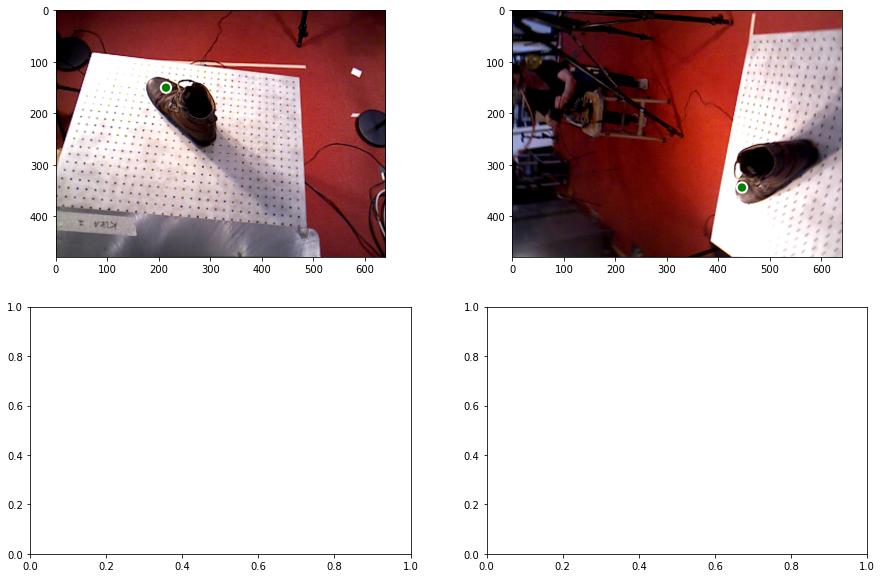

heatmap[v,u] 1.0
heatmap_255.dtype uint8
heatmap_255[v,u] 255
heatmap.max 1.0
heatmap min 3.4e-43


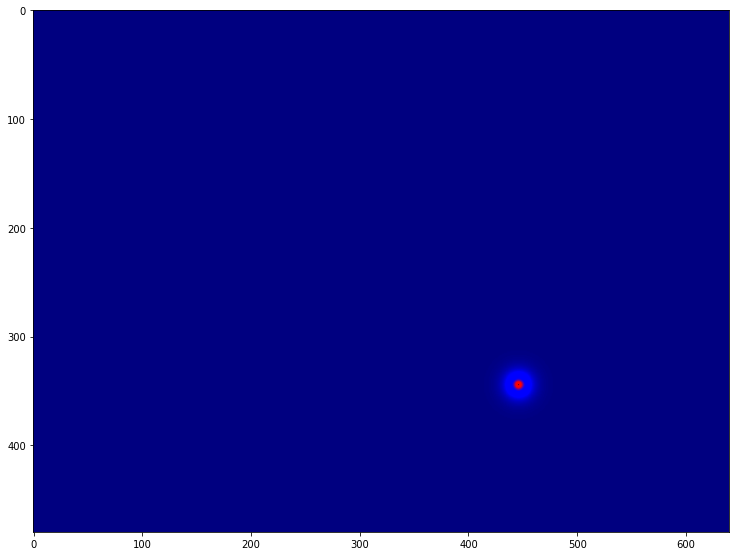

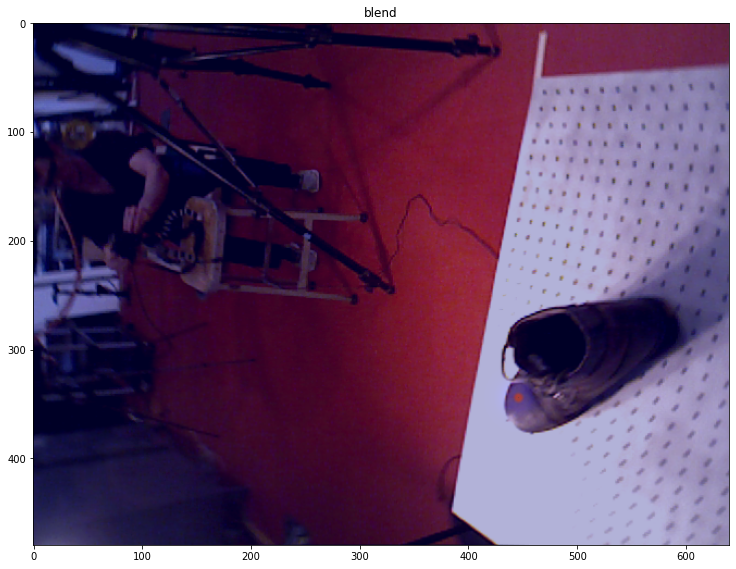

In [7]:


cd = dataset._getitem(episode, None, camera_name_a, camera_name_b, idx_a=idx_a, idx_b=idx_b)

pad_correspondence_data(cd, N_matches=10, N_masked_non_matches=20, N_background_non_matches=30, verbose=False)
uv_a = cd['matches']['uv_a']
uv_b = cd['matches']['uv_b']

H = cd['data_a']['rgb_tensor'].shape[1]
W = cd['data_a']['rgb_tensor'].shape[2]
sigma_fraction = 0.003
diag = np.sqrt(W**2 + H**2)
sigma = sigma_fraction * diag

print("H", H)
print("W", W)
# visualize some of them

# create heatmap
heatmap_tensor = loss_utils.create_heatmap(uv_b.permute([1,0]), H, W, sigma, type='exp')
print("heatmap_tensor.shape", heatmap_tensor.shape)


idx_range = range(1)
n = 0
uv_a_short = uv_a[:, idx_range]
uv_b_short = uv_b[:, idx_range]

print("uv_a_short", uv_a_short)
print("uv_b_short", uv_b_short)

print("uv_a", uv_a[:, :10])
print("uv_b", uv_b[:, :10])



# plot matches
# print(uv_a_short)
images = [data_a['rgb'], data_b['rgb']]
correspondence_plotter.plot_correspondences(images, uv_a_short, uv_b_short)

# plot heatmap
n = 0
heatmap = heatmap_tensor[n, :, :].unsqueeze(-1).expand(*[-1,-1,3]).numpy()
heatmap = heatmap_tensor[n, :, :].numpy()

print("heatmap[v,u]", heatmap[uv_b[1, n], uv_b[0, n]])

heatmap_255 = np.uint8(255*heatmap)
print("heatmap_255.dtype", heatmap_255.dtype)

print("heatmap_255[v,u]", heatmap_255[uv_b[1, n], uv_b[0, n]])

# this is in 'bgr', we want 'rgb'
colormap = cv2.applyColorMap(heatmap_255, cv2.COLORMAP_JET)
colormap_rgb = np.zeros_like(colormap)
colormap_rgb[:,:,0] = colormap[:,:,2]
colormap_rgb[:,:,2] = colormap[:,:,0]
print("heatmap.max", np.max(heatmap))
print("heatmap min", np.min(heatmap))

plt.figure(figsize=figsize)
plt.imshow(colormap_rgb)
plt.show()


alpha = 0.3
blend = alpha * colormap_rgb + (1-alpha) * data_b['rgb']
blend = np.int16(blend)
plt.figure(figsize=figsize)
plt.imshow(blend)
plt.title('blend')
plt.show()



if False:

    # plot non-matches
    masked_non_matches_uv_a = cd['masked_non_matches']['uv_a'][:, idx_range]
    masked_non_matches_uv_b = cd['masked_non_matches']['uv_b'][:, idx_range]
    correspondence_plotter.plot_correspondences(images, masked_non_matches_uv_a, 
                                                masked_non_matches_uv_b, circ_color='r')
    # plot non-matches
    background_non_matches_uv_a = cd['background_non_matches']['uv_a'][:, idx_range]
    background_non_matches_uv_b = cd['background_non_matches']['uv_b'][:, idx_range]
    correspondence_plotter.plot_correspondences(images, background_non_matches_uv_a, 
                                                background_non_matches_uv_b, circ_color='r')


    bnm_uv_a = cd['masked_non_matches']['uv_a']
    print("bnm_uv_a.dtype", bnm_uv_a.dtype)

    bnm_uv_b = cd['masked_non_matches']['uv_b']
    print("bnm_uv_b.dtype", bnm_uv_b.dtype)

In [8]:
print(get_data_root())

/home/manuelli/data/key_dynam
